# ECE657A_Assignment2_Group 24 (KAI MENG, CHI LIU, ZIZHENG JIANG)

# Part1

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Q1

In [2]:
df = pd.read_csv('bank-additional.csv', index_col = None, header = 0)

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [4]:
np.shape(df)

(4119, 21)

In [5]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Dealing with 'unknown' data of categorical features 

We have 4119 observations in total. For the categorial features containing entries which are 'unknown', if it is not a very big portion, we will replace the unknown entries with the most frequent entry in the corresponding feature. By using this method, we are able to fill out the "unknowns" and meanwhile, reduce the bias as much as possible. 

In [6]:
header = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week','poutcome']

In [7]:
for col in header:
    print(col, np.unique(df[col], return_counts=True))

job (array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'], dtype=object), array([1012,  884,  148,  110,  324,  166,  159,  393,   82,  691,  111,
         39]))
marital (array(['divorced', 'married', 'single', 'unknown'], dtype=object), array([ 446, 2509, 1153,   11]))
education (array(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
       'professional.course', 'university.degree', 'unknown'], dtype=object), array([ 429,  228,  574,  921,    1,  535, 1264,  167]))
default (array(['no', 'unknown', 'yes'], dtype=object), array([3315,  803,    1]))
housing (array(['no', 'unknown', 'yes'], dtype=object), array([1839,  105, 2175]))
loan (array(['no', 'unknown', 'yes'], dtype=object), array([3349,  105,  665]))
contact (array(['cellular', 'telephone'], dtype=object), array([2652, 1467]))
month (array(['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may'

From the output in above cell, we know that:
job has 39 unknown,
marital has 11 unknown,
education has 167 unknown,
default has 803 unknown,
housing has 105 unknown,
loan has 105 unknown.

We apply the method of replacing the unknowns with the most frequent entry in the corrsponding feature.

In [8]:
df["job"].replace("unknown", 'admin.', inplace=True)
df["marital"].replace("unknown", "married", inplace=True)
df["education"].replace("unknown", "university.degree", inplace=True)
df["default"].replace("unknown", "no", inplace=True)
df["housing"].replace("unknown", "yes", inplace=True)
df["loan"].replace("unknown", "no", inplace=True)

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,yes,no,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Dealing with outliers

For entries in columns 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'. If the entry is outside the 2 standard deviation range, we will treat it as outlier and replace with the feature mean.

In [10]:
# deal with outliers
outliers = []
for head in ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']:
    count = 0
    sum = 0
    for row in df[head]:
        if not math.isnan(row):
            count = count + 1
            sum = sum + row
    mean = sum*1.0 / count
    var = 0
    for row in df[head]:
        if not math.isnan(row):
            var = var + ((row - mean)*(row - mean))
    std = np.sqrt(var*1.0/count)
    outliersNum = 0
    for row in df[head]:
        if not math.isnan(row):
            if abs(row - mean) > 2*std:
                outliersNum += 1
                row = mean
    outliers.append(outliersNum)
print('# of outliers in emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed {}'.format(outliers))

# of outliers in emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed [104, 124, 153, 0, 334]


In [11]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,yes,no,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Dropping useless features

According to the data description, the feature "duration" will highly affect the output when constructing preditve model, and needs to be dropped.

In [12]:
df.drop('duration', axis = 1, inplace = True)

In [13]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,yes,no,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [14]:
np.shape(df)

(4119, 20)

### Dealing with categorial features

Mapping categorial features to numeric data. In order to use the classification models, we need to convert the categorial features to numeric data, we will use the following mapping method to do this. For binary features, mapping as 0 and 1. For categorial features containing orders like "education", "month" and "dayofweek", we will map it accordingly. 

In [15]:
contact_map={'cellular':0, 'telephone':1}
df["contact"]=df["contact"].map(contact_map)

education_map={'basic.4y':2, 'basic.6y':3, 'basic.9y':4, 'high.school':5, 'illiterate':1,
 'professional.course':6, 'university.degree':7}
df["education"] = df["education"].map(education_map)

loan_map={"no":0, "yes":1}
df["loan"]=df["loan"].map(loan_map)

default_map={"no":0, "yes":1}
df["default"]=df["default"].map(default_map)

month_map={'apr':4, 'aug':8, 'dec':12, 'jul':7, 'jun':6, 'mar':3, 'may':5, 'nov':11, 'oct':10, 'sep':9}
df["month"]=df["month"].map(month_map)

housing_map={"no":0, "yes":1}
df["housing"]=df["housing"].map(default_map)

dayofweek_map={'fri':5, 'mon':1, 'thu':4, 'tue':2, 'wed':3}
df["day_of_week"]=df["day_of_week"].map(dayofweek_map)

y_map={'no':0, 'yes':1}
df["y"]=df["y"].map(y_map)

#for marital feature, treat married as 1 and non-married as 0
marital_map={'divorced':0, 'married':1, 'single':0}
df["marital"]=df["marital"].map(marital_map)

In [16]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,1,4,0,1,0,0,5,5,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,0,5,0,0,0,1,5,5,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,1,5,0,1,0,1,6,3,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,1,4,0,1,0,1,6,5,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,1,7,0,1,0,0,11,1,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


For the categorial features not containing any order, like "job", we are going to use dummy variables to convert them to binary features.

In [17]:
#store the original categorial features of job and poutcome
poutcome_col = df["poutcome"]
job_col = df["job"]
#create dummy variables
poutcome = pd.get_dummies(df['poutcome'], prefix = 'poutcome')
job = pd.get_dummies(df['job'], prefix = 'job')
df = df.join([job,poutcome])
df.drop("job", axis=1, inplace=True)
df.drop("poutcome", axis=1, inplace=True)

In [18]:
df.head()

,age,marital,education,default,housing,loan,contact,month,day_of_week,campaign,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,30,1,4,0,1,0,0,5,5,2,...,0,0,0,0,0,0,0,0,1,0
1,39,0,5,0,0,0,1,5,5,4,...,0,0,0,1,0,0,0,0,1,0
2,25,1,5,0,1,0,1,6,3,1,...,0,0,0,1,0,0,0,0,1,0
3,38,1,4,0,1,0,1,6,5,3,...,0,0,0,1,0,0,0,0,1,0
4,47,1,7,0,1,0,0,11,1,1,...,0,0,0,0,0,0,0,0,1,0


In [19]:
np.shape(df)

(4119, 32)

### Get X and y from the full dataset and conduct normalization

In [20]:
y = df["y"]
df.drop("y", inplace=True, axis=1)
scaler = StandardScaler(with_mean=True, with_std=True)
df_norm=scaler.fit_transform(df)

In [21]:
np.shape(df_norm)

(4119, 31)

## Q2

The original set was divided randomly to 33% as test set and 67% as training set.
The rationale given is that if you lower the number of samples in the training, the samples for the model being built will have too few samples to come up with a convincing model.
Usually the dataset are divided into training(60%-80%) set and testing(20%-40%) set.
The sklearn library will split arrays or matrices into random train and test subsets so that help us to reduce the overfit problem. 
The sklearn library uses the random number generator to decide how to split the dataset and uses the shuffle method as well.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_norm, y, test_size=0.33, random_state=42)

## Q3

### Decision Tree

In [23]:
max_test_score = 0
MaxDepth=[]
TestScore=[]
TrainScore=[]
for i in range(1, 20):
    MaxDepth.append(i)
    clf_dt = DecisionTreeClassifier(max_depth=i)
    clf_dt.fit(X_train, y_train)
    train_score = clf_dt.score(X_train, y_train)
    test_score = clf_dt.score(X_test, y_test)
    TestScore.append(test_score)
    TrainScore.append(train_score)
    if test_score > max_test_score:
        related_train_score = train_score
        max_test_score = test_score
        max_i = i
        best_clf_dt = clf_dt
print("depth: ", max_i, "train: ", related_train_score)
print("depth: ", max_i, "test: ", max_test_score)

depth:  2 train:  0.902863356289
depth:  2 test:  0.902941176471


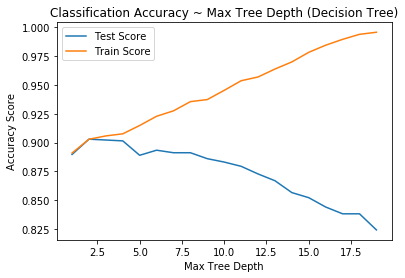

In [24]:
plt.plot(MaxDepth, TestScore, label = 'Test Score')
plt.plot(MaxDepth, TrainScore, label = 'Train Score')
plt.title('Classification Accuracy ~ Max Tree Depth (Decision Tree)')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

By choosing the various "max_depth" of our decision tree classifier, we found out that when max_depth = 2, it gave us the best classification accuracy in terms of the test set. And if we increase the max_depth after 2, the training set accuracy score will keep rising, however, the test set accuracy score will decrease, implying overfit on the training set. Given the analysis above, we will use max_depth = 2 as the property for our decision tree classifier from here.

Algorithm implemented: the sklearn library uses an optimized version of the CART(classification and regression tree) algorithm. The CART algorithm is structured as a sequence of questions, the answers to which determine what the next question. The result of these questions is a tree like structure where the ends are terminal nodes at which point there are no more questions. The main elements of CART are: Rules for splitting the data at a node based on the value of one variable; Stopping rules for deciding when to stop spliting and reaching the leaf nodes; The prediction for the preditor variable in each terminal node.

### Random Forest

In [25]:
max_test_score = 0
TreeNum=[]
MaxDepth=[]
TestScore=[]
TrainScore=[]
for j in range(1, 30):
    for i in range(1, 30):
        clf_rf = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=j, max_depth=i)
        clf_rf.fit(X_train, y_train)
        train_score = clf_rf.score(X_train, y_train)
        test_score = clf_rf.score(X_test, y_test)
        if test_score > max_test_score:
            related_train_score = train_score
            max_test_score = test_score
            max_i = i
            max_j = j
            best_clf_rf = clf_rf
        TreeNum.append(j)
        MaxDepth.append(i)
        TrainScore.append(train_score)
        TestScore.append(test_score)
print("tree_num: ", max_j, "depth: ", max_i, "train accuracy ", related_train_score)
print("tree_num: ", max_j, "depth: ", max_i, "test accuracy", max_test_score)

tree_num:  5 depth:  4 train accuracy  0.904675607104
tree_num:  5 depth:  4 test accuracy 0.904411764706


For the random forest classfier, two main parameters are number of trees and the max depth of trees. Given the iterations performed above, when number of trees is 5 and max_depth = 4, we obtain the optimal classification accuracy in terms of the test set. And from here, we will use n_estimators = 5, max_depth = 4 in our random forest classifier.

With the sklearn random forests classifier, each tree is built from a sample drawn from the training set with replacement (i.e., a bootstrap sample), also the sample has K features. We will use CART tree training algorithm for each tree, at each split, it will find the optimal split by searching the K features and their values. And for the next tree, it will use a different sample of features and observations. That is to say, when splitting a node, the split that is chosen is no longer the best split among all features. Instead, it is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

### Neural Networks

In [92]:
max_test_score = 0
for i in range(1,10):
    for j in range(1, 10):
        clf_mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i, j), random_state=0)
        clf_mlp.fit(X_train, y_train)
        train_score = clf_mlp.score(X_train, y_train)
        test_score = clf_mlp.score(X_test, y_test)
        if test_score > max_test_score:
            related_train_score = train_score
            max_test_score = test_score
            max_i = i
            max_j = j
            best_clf_mlp = clf_mlp
print(best_clf_mlp)
print("1st hl nodes num: ", max_i, "; 2nd hl nodes num: ", max_j, "; train score: ", related_train_score, "; test score: ", max_test_score)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
1st hl nodes num:  2 ; 2nd hl nodes num:  3 ; train score:  0.903588256615 ; test score:  0.901470588235


For the neural networks, we used the MLPClassifier from sklearn library. To save the running time and maintain a good classification accuracy performance, we set the number of hidden layers as 2. And given the above iterations perfromed, we obtained the best classification accuracy score in terms of the test set when number of nodes in the first hidden layer is 2 and 3 in the second hidden layer. From here, we will use as our NNs model, i.e. 2 hidden layers, 2 nodes in the first hidden layer and 3 nodes in the second hidden layer.

The activation function implemented is ReLU and the solver is ‘lbfgs’ which is an optimizer in the family of quasi-Newton methods.

## Q4

In [99]:
df.head()

,age,marital,education,default,housing,loan,contact,month,day_of_week,campaign,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,30,1,4,0,1,0,0,5,5,2,...,0,0,0,0,0,0,0,0,1,0
1,39,0,5,0,0,0,1,5,5,4,...,0,0,0,1,0,0,0,0,1,0
2,25,1,5,0,1,0,1,6,3,1,...,0,0,0,1,0,0,0,0,1,0
3,38,1,4,0,1,0,1,6,5,3,...,0,0,0,1,0,0,0,0,1,0
4,47,1,7,0,1,0,0,11,1,1,...,0,0,0,0,0,0,0,0,1,0


In [116]:
df.columns

Index(['age', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

In [103]:
X_test_back = scaler.inverse_transform(X_test)

### Decision tree classifier output

In [108]:
best_clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

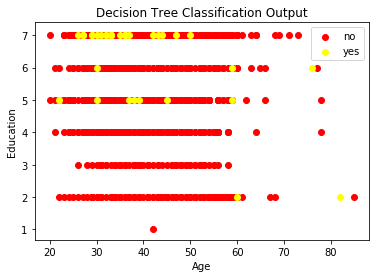

In [112]:
plt.figure()
classLable = ['no', 'yes']
colors = ['red', 'yellow']
y_pred = best_clf_dt.predict(X_test)
for color, i, class_name in zip(colors, [0, 1], classLable):
    plt.scatter(X_test_back[y_pred == i, 0], X_test_back[y_pred == i, 2], color = color, label = class_name)
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('Decision Tree Classification Output')
plt.xlabel('Age')
plt.ylabel('Education')
plt.show()

Using the decision tree classifier, and plotting the test set on two dimensions which are "Age" and "Education". As we can see from the above figure, the higher the education level is, the more likely the client will subscribe the term deposit. Meanwhile, when the client's age lies in the range of (25,50), the client is more likely to subscribe the term deposit.

### Random forest classifier output

In [114]:
best_clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

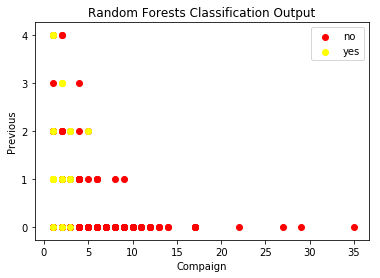

In [117]:
plt.figure()
classLable = ['no', 'yes']
colors = ['red', 'yellow']
y_pred = best_clf_rf.predict(X_test)
for color, i, class_name in zip(colors, [0, 1], classLable):
    plt.scatter(X_test_back[y_pred == i, 9], X_test_back[y_pred == i, 11], color = color, label = class_name)
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('Random Forests Classification Output')
plt.xlabel('Compaign')
plt.ylabel('Previous')
plt.show()

Using the random forests classifier, and plotting the test set on two dimensions which are "Compaign" and "Previous". "Campaign" means the number of contacts performed during this campaign and for this client. "Previous" means the number of contacts performed before this campaign and for this client. As we can see from the above figure, if the number of contacts during this compaign is lower, the client is more likely to subscribe the term deposit. And the proportion of clients subsribing the term deposit is higher if they were contacted more before this compaign. 

### MLP classifier output

In [118]:
best_clf_mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

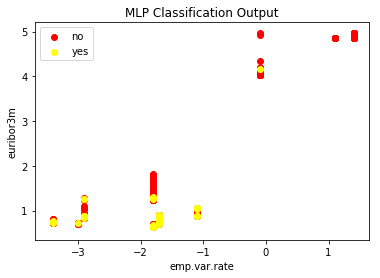

In [122]:
plt.figure()
classLable = ['no', 'yes']
colors = ['red', 'yellow']
y_pred = best_clf_mlp.predict(X_test)
for color, i, class_name in zip(colors, [0, 1], classLable):
    plt.scatter(X_test_back[y_pred == i, 12], X_test_back[y_pred == i, 15], color = color, label = class_name)
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('MLP Classification Output')
plt.xlabel('emp.var.rate')
plt.ylabel('euribor3m')
plt.show()

Using the MLP classifier, and plotting the test set on two dimensions which are "emp.var.rate" and "euribor3m". "emp.var.rate" means the employment variation rate, and "euribor3m" means the euribor 3 month rate. As we can tell from the above figure, as the emp.var.rate goes up, the likelihood of subscribing will decrease. And the same pattern is existing in terms of the feature euribor3m.

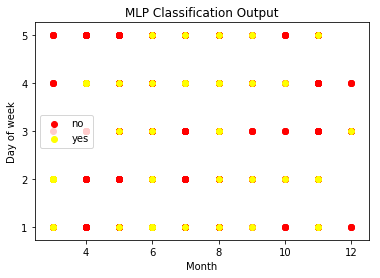

In [123]:
plt.figure()
classLable = ['no', 'yes']
colors = ['red', 'yellow']
y_pred = best_clf_mlp.predict(X_test)
for color, i, class_name in zip(colors, [0, 1], classLable):
    plt.scatter(X_test_back[y_pred == i, 7], X_test_back[y_pred == i, 8], color = color, label = class_name)
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('MLP Classification Output')
plt.xlabel('Month')
plt.ylabel('Day of week')
plt.show()

Using the MLP classifier, and plotting the test set on two dimensions which are "month" and "day_of_week". From the figure above, there is no clear characteristics that can help us distiguish the classes based on different months or various day of week.

From the above analysis, we can tell that on dimensions like "Age", "Education" and "Compaign", the separation between these two classes is better, however, on dimensions like "Month" and "Day of week", the separation is not that obvious. The reason is that features like "Age" and "Education" have greater effects on clients' decision making and can better discriminate between classes, however, features like "Month" and "Day of week" do not have the power to discriminate between classes or have little effects on clients' decision making.

## Q5

In [168]:
y_true = y_test
y_dt_pred = best_clf_dt.predict(X_test)
y_rf_pred = best_clf_rf.predict(X_test)
y_mlp_pred = best_clf_mlp.predict(X_test)

### Confusion matrics

In [169]:
print("Confusion matrix of Decision tree classifier prediction")
cnf_matrix = confusion_matrix(y_true, y_dt_pred)
print(cnf_matrix)
print("Confusion matrix of Random forest classifier prediction")
cnf_matrix = confusion_matrix(y_true, y_rf_pred)
print(cnf_matrix)
print("Confusion matrix of MLP classifier prediction")
cnf_matrix = confusion_matrix(y_true, y_mlp_pred)
print(cnf_matrix)

Confusion matrix of Decision tree classifier prediction
[[1202    8]
 [ 124   26]]
Confusion matrix of Random forest classifier prediction
[[1202    8]
 [ 122   28]]
Confusion matrix of MLP classifier prediction
[[1194   16]
 [ 118   32]]


The confusion matrix of predictions under each classifier is shown above. Labels for rows are "Actual no" and "Actual yes". Labels for columns are "Predicted no" and "Predicted yes". For example, the first confusion matrix of decision tree classifier, 1202 is the counts for TN(true negative), 8 is for FP(false positive), 124 is for FN(false positive), and 26 is for TP(true positive).

### Classification reports

In [170]:
print("Decision tree classifier prediction evaluation")
print(classification_report(y_true, y_dt_pred, target_names=['no', 'yes']))
print("Random forest classifier prediction evaluation")
print(classification_report(y_true, y_rf_pred, target_names=['no', 'yes']))
print("MLP classifier prediction evaluation")
print(classification_report(y_true, y_mlp_pred, target_names=['no', 'yes']))

Decision tree classifier prediction evaluation
             precision    recall  f1-score   support

         no       0.91      0.99      0.95      1210
        yes       0.76      0.17      0.28       150

avg / total       0.89      0.90      0.87      1360

Random forest classifier prediction evaluation
             precision    recall  f1-score   support

         no       0.91      0.99      0.95      1210
        yes       0.78      0.19      0.30       150

avg / total       0.89      0.90      0.88      1360

MLP classifier prediction evaluation
             precision    recall  f1-score   support

         no       0.91      0.99      0.95      1210
        yes       0.67      0.21      0.32       150

avg / total       0.88      0.90      0.88      1360



The classification evaluation tables are shown above. In the table, precision is TP/(TP + FP), recall is TP/(TP + FN), and the f1-score can be interpreted as a weighted harmonic mean of the precision and recall.

### Bar charts comparison

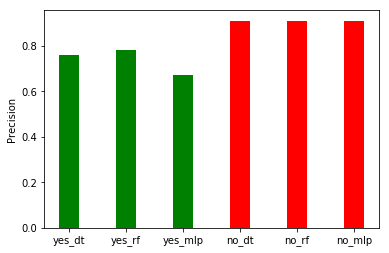

In [171]:
n_groups = 6
clf_yes, clf_no = [0.76, 0.78, 0.67], [0.91, 0.91, 0.91]
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35
dt_yes = plt.bar(index[0] + bar_width, clf_yes[0], bar_width, color='g', label='Yes')
dt_no = plt.bar(index[3] + bar_width, clf_no[0], bar_width, color='r', label='No')

rf_yes = plt.bar(index[1] + bar_width, clf_yes[1], bar_width, color='g', label='Yes')
rf_no = plt.bar(index[4] + bar_width, clf_no[1], bar_width, color='r', label='No')

mlp_yes = plt.bar(index[2] + bar_width, clf_yes[2], bar_width, color='g', label='Yes')
mlp_no = plt.bar(index[5] + bar_width, clf_no[2], bar_width, color='r', label='No')

ax.set_ylabel('Precision')
plt.xticks(index + bar_width, ('yes_dt', 'yes_rf', 'yes_mlp', 'no_dt', 'no_rf', 'no_mlp'))
plt.show()

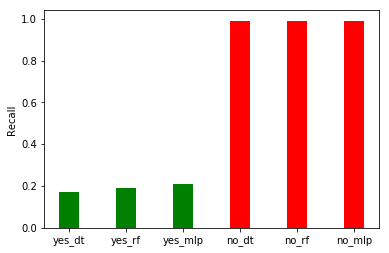

In [172]:
n_groups = 6
clf_yes, clf_no = [0.17, 0.19, 0.21], [0.99, 0.99, 0.99]
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35
dt_yes = plt.bar(index[0] + bar_width, clf_yes[0], bar_width, color='g', label='Yes')
dt_no = plt.bar(index[3] + bar_width, clf_no[0], bar_width, color='r', label='No')

rf_yes = plt.bar(index[1] + bar_width, clf_yes[1], bar_width, color='g', label='Yes')
rf_no = plt.bar(index[4] + bar_width, clf_no[1], bar_width, color='r', label='No')

mlp_yes = plt.bar(index[2] + bar_width, clf_yes[2], bar_width, color='g', label='Yes')
mlp_no = plt.bar(index[5] + bar_width, clf_no[2], bar_width, color='r', label='No')

ax.set_ylabel('Recall')
plt.xticks(index + bar_width, ('yes_dt', 'yes_rf', 'yes_mlp', 'no_dt', 'no_rf', 'no_mlp'))
plt.show()

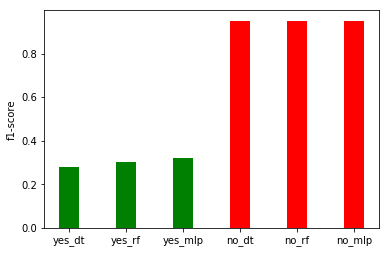

In [173]:
n_groups = 6
clf_yes, clf_no = [0.28, 0.3, 0.32], [0.95, 0.95, 0.95]
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35
dt_yes = plt.bar(index[0] + bar_width, clf_yes[0], bar_width, color='g', label='Yes')
dt_no = plt.bar(index[3] + bar_width, clf_no[0], bar_width, color='r', label='No')

rf_yes = plt.bar(index[1] + bar_width, clf_yes[1], bar_width, color='g', label='Yes')
rf_no = plt.bar(index[4] + bar_width, clf_no[1], bar_width, color='r', label='No')

mlp_yes = plt.bar(index[2] + bar_width, clf_yes[2], bar_width, color='g', label='Yes')
mlp_no = plt.bar(index[5] + bar_width, clf_no[2], bar_width, color='r', label='No')

ax.set_ylabel('f1-score')
plt.xticks(index + bar_width, ('yes_dt', 'yes_rf', 'yes_mlp', 'no_dt', 'no_rf', 'no_mlp'))
plt.show()

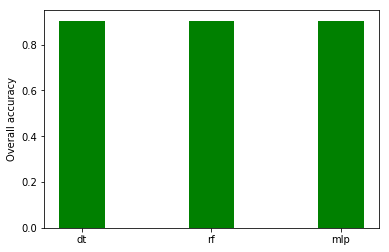

In [175]:
n_groups = 3
clf_accuracy = [(1202+26)/(1210+150), (1202+28)/(1210+150), (1194+32)/(1210+150)]
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35
dt_yes = plt.bar(index[0] + bar_width, clf_accuracy[0], bar_width, color='g', label='Yes')

rf_yes = plt.bar(index[1] + bar_width, clf_accuracy[1], bar_width, color='g', label='Yes')

mlp_yes = plt.bar(index[2] + bar_width, clf_accuracy[2], bar_width, color='g', label='Yes')

ax.set_ylabel('Overall accuracy')
plt.xticks(index + bar_width, ('dt', 'rf', 'mlp'))
plt.show()

Intuitively, there is no big difference when comparing the overall prediction accuracies of the three models being used. However, obviously for all three models, the classification recall scores and f1-scores for class "no" is extremely higher than the classification accuracy for class "yes". This kind of discrepancy is reduced when considering precision score as criteria.

## Q6

From the confusion matrix, we can tell how many datapoints we get the correct predictions with respect to their actual class labels, as well as how many datapoints our models get predicted wrong given the labels. This can also be interpreted from the "recall" column in the classification reports. As already been discussed in Q5, all the three models work better in predicting the "no" class, but perform badly in predicting the "yes" class. If we take a look at the precision score, the discrepancy between the "yes" and "no" classes becomes much lower compared to using the recall score. In terms of the f1-score, it gives us a comprehensive evaluation combining precision and recall, still, discrepancy between "yes" and "no" classes is obvious, implying the intrinsic inbalance in the original dataset. 

To compare, in terms of the actual "no" class, there is no big difference in the performances of the three models. When talking about predicting the actual "yes" class, the MLP classifier(NNs) gives the best output, and random forest is slightly better than decision tree classifier. The reason may be that random forests is more robust compared to decision tree, using more treats generally will improve accuracy and reduce variance. When it comes to ANNs, it can better learn the hidden relationships in the data and rarely has restrictions on the input variables.

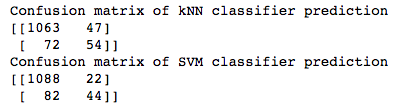

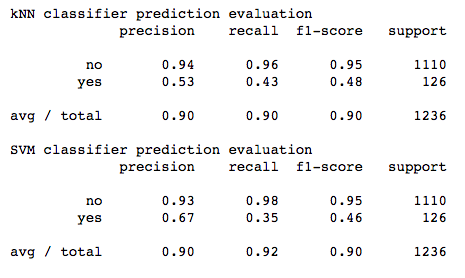

The previous hw5 implementation of kNN and SVM classifiers on numeric features only give us the classification outputs as shown above. The overall accuracy does not differ too much from what we get from decision tree, random forests and neural networks. However, considering the precision score, kNN's and SVM's are lower for "yes" class, speaking about recall score, kNN's and SVM's are higher than dt, rf and mlp. The reason may be when we taking the categorial features into account, more information are provided, but it can not be guaranteed that the performance will be better. Depending on the correaltions between features and preditor variable, whether or not it is redundent, the performance will differ. And it is better for us to use effective feature selection and extraction process before applying the classification algorithms.

## Q7

In [96]:
df_all = pd.concat([df,y], axis = 1)
df_0 = df_all.loc[df_all["y"] == 0]
df_1 = df_all.loc[df_all["y"] == 1]
df_0_sub = df_0.sample(frac = 0.15)
df_new = pd.concat([df_0_sub, df_1], axis = 0)

In [97]:
y_new = df_new["y"]
df_new.drop("y", inplace=True, axis=1)
scaler = StandardScaler(with_mean=True, with_std=True)
df_norm_new=scaler.fit_transform(df_new)

In [98]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_norm_new, y_new, test_size=0.33, random_state=42)

In [99]:
clf_rf_new = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=5, max_depth=4)
clf_rf_new.fit(X_train_new, y_train_new)
y_pred_new = clf_rf_new.predict(X_test_new)

In [100]:
cnf_matrix = confusion_matrix(y_test_new, y_pred_new)
cnf_matrix

array([[161,  26],
       [ 58,  86]])

In [101]:
print(classification_report(y_test_new, y_pred_new, target_names=['no', 'yes']))

             precision    recall  f1-score   support

         no       0.74      0.86      0.79       187
        yes       0.77      0.60      0.67       144

avg / total       0.75      0.75      0.74       331



Looking into the distribution of the classes, there are over 3600 observations with label 0 and only less than 500 entries with label 1, indicating strong imbalance. We randomly select 15% of the entries with label 0 and combine them with all the entries with label 1. Then, we conduct the classification using random forest classifier with the same parameters in above questions. The confusion matrix and report are shown above. We can see the classification discrepancy between two classes is mitigated. The "recall" score of "no" class increases from 0.17 to 0.6, for "yes" class, it decreases a little.

# Part 2

## Q1

In [1]:
import numpy as np
import scipy.io as sio
df = sio.loadmat('DataDNA.mat')
X = df['fea']
y = df['gnd']
y = np.asarray([j for i in y for j in i])
print(X)
print(y)

[[1 2 1 ..., 2 2 1]
 [3 3 4 ..., 1 3 4]
 [4 1 4 ..., 2 4 4]
 ..., 
 [3 4 4 ..., 3 1 2]
 [1 4 3 ..., 4 3 4]
 [4 3 1 ..., 2 4 3]]
[1 1 1 ..., 1 1 1]


In [2]:
# Preprocessing using Z-score normalization
from sklearn.preprocessing import StandardScaler
zscaler = StandardScaler()
X_norm = zscaler.fit_transform(X)
print(X_norm)

[[-1.35289759 -0.48747864 -1.37244139 ..., -0.4584159  -0.41756618
  -1.39224875]
 [ 0.45920268  0.43308188  1.36002111 ..., -1.37441497  0.49741947
   1.36965138]
 [ 1.36525282 -1.40803915  1.36002111 ..., -0.4584159   1.41240513
   1.36965138]
 ..., 
 [ 0.45920268  1.35364239  1.36002111 ...,  0.45758317 -1.33255183
  -0.47161537]
 [-1.35289759  1.35364239  0.44920027 ...,  1.37358225  0.49741947
   1.36965138]
 [ 1.36525282  0.43308188 -1.37244139 ..., -0.4584159   1.41240513
   0.44901801]]


/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Z-score normalization vs Min-max normalization

The algorithms that we choose to implement are kNN, SVM, Random forest and Simple Neural networks. For kNN algorithm, it relys on the distance between datapoints to do the classification, in this case, z-score normalization will make all features contribute equally. For SVM and neural networks, after the z-score normalization, some weights which depend on the final result in the algorithms will update faster. In addition, some algorithms assume that our data is centered at 0. For example, if we initialize the weights of a small multi-layer perceptron with tanh activation units to 0 or small random values centered around zero, z-score normalization will help to update the model weights equally. For random forest, we want to find direction to split the trees and features. Z-score normalization will make the features on the same scale. In this case, Z-score normalization is better than min-max normalization.

### Why do you need normalization in general?

Normalization makes training less sensitive to the scale of features and makes regularization behave differently for different scaling. It also keeps consistency for comparing results across models and makes optimization well-conditioned.

In [3]:
#train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)

### Justify why you would normally split the test and training set randomly

Because selecting the test and train set randomly is meant to be an unbiased representation of our dataset. In this case, we can improve robustness, reduce the errors and unexpected effects of the models. 

In [4]:
#Distribution of the +1, -1 classes
count_pos_1 = 0
count_neg_1 = 0
for i in y:
    if i == 1:
        count_pos_1 = count_pos_1 + 1
    if i == -1:
        count_neg_1 = count_neg_1 + 1
print("+1 counts: ", count_pos_1)
print("-1 counts: ", count_neg_1)
ratio_pos_1 = count_pos_1*1.0/(count_pos_1 + count_neg_1)
ratio_neg_1 = count_neg_1*1.0/(count_pos_1 + count_neg_1)
print("class 1 ratio(distribution):" , ratio_pos_1)
print("class -1 ratio(distribution):" , ratio_neg_1)

+1 counts:  1137
-1 counts:  1063
class 1 ratio(distribution): 0.5168181818181818
class -1 ratio(distribution): 0.48318181818181816


### Distribution of +1 , -1 classes

With respect to the above ratios, the distributions of the +1 and -1 classes is almost uniform. The ratios are both around 0.5.

## Q2

### a

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

knn_param = []
accuracy = []
i = 1
max_k = 0
max_score = 0
while i <= 31:
    knn_param.append(i)
    clf_knn = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(clf_knn, X_train, y_train, cv = 5)
    score = scores.mean()
    accuracy.append(score)
    i = i + 2
    if score > max_score:
        max_score = score
        max_k = i

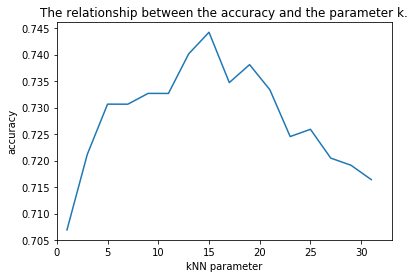

max score:  0.744210769053 when k =  17


In [6]:
plt.figure('k_param vs accuracy')
plt.title('The relationship between the accuracy and the parameter k.')
plt.plot(knn_param, accuracy)
plt.xlabel("kNN parameter")
plt.ylabel("accuracy")
plt.xlim((0,33))
plt.show()
print("max score: ", max_score, "when k = ", max_k)

### Report the best k in terms of classification accuracy

Best k = 17. the best score is shown in the above figure.

### Explain why you didn’t evaluate directly on the test set:

For the model evaluation, we would like to select the model which gives us the best classification accuracy in terms of the brand new unseen test set. So if we directly use the test set during the parameter selection period, it is somehow equivalent to using the test set to train the model, the model we get eventually may perform badly on brand new test set, which is not ideal at all.

### b

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# RBF SVM
max_score = 0
c = [0.1, 0.5, 1, 2, 5, 10, 20, 50]
sigma = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
gamma = []
for num in sigma:
    gamma.append(1/(2*num*num))
for i in c:
    for j in gamma:
        clf_svm = SVC(C=i, kernel='rbf', gamma=j)
        scores = cross_val_score(clf_svm, X_train, y_train, cv = 5)
        score = scores.mean()
        if score > max_score:
            max_score = score
            max_c = i
            max_gamma = j
            max_sigma = np.sqrt(1/(2*j))
print("max_c: ", max_c, "max_gamma: ", max_gamma, "max_sigma: ", max_sigma)

max_c:  20 max_gamma:  0.005 max_sigma:  10.0


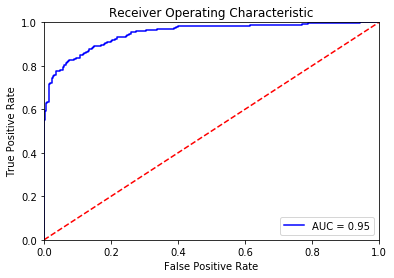

In [42]:
# ROC plot
best_clf_svm = SVC(C=20, kernel='rbf', gamma=0.005, probability=True)
best_clf_svm.fit(X_train, y_train)
probs = best_clf_svm.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Best c and sigma in terms of classification accuracy

c = 20, sigma = 10, gamma = 0.005
ROC plot is the above figure.

Based on the iterations we did above, when c = 20 and gamma =0.005 (sigma = 10) , we can get the best result for the RBF SVM model according to the cross validation score. The ROC plot is based on the best result with the parameters of c and gamma.

## Q3

### a

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
best_clf_knn = KNeighborsClassifier(n_neighbors= 17)
best_clf_svm = SVC(C=20, kernel='rbf', gamma=0.005)
default_clf_rf = RandomForestClassifier(min_samples_leaf=1)
default_clf_mlp = MLPClassifier(activation = 'tanh', solver='sgd', hidden_layer_sizes=(10,))
best_clf_knn.fit(X_train, y_train)
best_clf_svm.fit(X_train, y_train)
default_clf_rf.fit(X_train, y_train)
default_clf_mlp.fit(X_train, y_train)

print("kNN test score:",best_clf_knn.score(X_test, y_test))
print("SVM test score:",best_clf_svm.score(X_test, y_test))
print("RF test score:",default_clf_rf.score(X_test, y_test))
print("MLP test score:",default_clf_mlp.score(X_test, y_test))

kNN test score: 0.727272727273
SVM test score: 0.870523415978
RF test score: 0.932506887052
MLP test score: 0.81129476584


/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



### kNN, SVM, default rf, default mlp

In this case, we have 4 models. kNN with k = 17, SVM with c = 20, sigma = 10 and a default random forest model and a default MLP model.

### b

In [29]:
### RF model selection
max_score = 0
for j in range(1, 20):
    for i in range(1, 20):
        clf_rf = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=j, max_depth=i)
        scores = cross_val_score(clf_rf, X_train, y_train, cv = 5)
        score = scores.mean(0)
        if score > max_score:
            max_score = score
            max_i = i
            max_j = j

print("tree nums: ", max_j, "tree depth: ", max_i, "score: ", max_score)

tree nums:  18 tree depth:  6 score:  0.957938429609


### Best random forest model selection

According to the code above, we use a nested for loop to change the n_estimators(number of trees) and max_depth(depth of the trees) and compared the accuracy results. In this case, optimal number of trees is 18, optimal maximun tree depth is 6.

In [21]:
### MLP model selection
max_score = 0
for i in range(1,20):
    for j in range(1, 20):
        clf_mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i, j), random_state=0,activation='tanh')
        scores = cross_val_score(clf_mlp, X_train, y_train, cv = 5)
        score = scores.mean()
        if score > max_score:
            max_score = score
            max_i = i
            max_j = j
            best_clf_mlp = clf_mlp
print(best_clf_mlp)
print(max_i, max_j, "score: ", max_score)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 7), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
4 7 score:  0.844635074369


### Best MLP model selection

According to the above code, the nested loop has been used to determine the best MLP model.
In this case, the solver is "lbfgs", the hidden layer size is 2 with 4 nodes in the first hidden layer and 7 in the second.

### c

In [38]:
### contribute model
best_clf_rf = RandomForestClassifier(random_state=0, n_estimators=18, max_depth=6)

bes_clf_mlp = MLPClassifier(activation = 'tanh',solver='lbfgs', hidden_layer_sizes=(4,7))

best_clf_knn = KNeighborsClassifier(n_neighbors= 17)

best_clf_svm = SVC(C=20, kernel='rbf', gamma=0.005)

default_clf_rf = RandomForestClassifier(min_samples_leaf=1)

default_clf_mlp = MLPClassifier(activation = 'tanh',solver='sgd', hidden_layer_sizes=(10,))

In [39]:
train_time_knn=[]
train_time_svm=[]
train_time_best_rf=[]
train_time_best_mlp=[]
train_time_default_rf=[]
train_time_default_mlp=[]

classification_time_knn=[]
classification_time_svm=[]
classification_time_best_rf=[]
classification_time_best_mlp=[]
classification_time_default_rf=[]
classification_time_default_mlp=[]

knn_acu = []
svm_acu = []
best_rf_acu = []
best_mlp_acu = []
default_rf_acu = []
default_mlp_acu = []

knn_pre = []
svm_pre = []
best_rf_pre = []
best_mlp_pre = []
default_rf_pre = []
default_mlp_pre = []

knn_rec = []
svm_rec = []
best_rf_rec = []
best_mlp_rec = []
default_rf_rec = []
default_mlp_rec = []

knn_f1 = []
svm_f1 = []
best_rf_f1 = []
best_mlp_f1 = []
default_rf_f1 = []
default_mlp_f1 = []

In [40]:
import timeit
import numpy as np
from random import randint
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

for i in range(20):
    state = randint(0, 99)
    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state= state)
    
    ### knn
    start = timeit.default_timer()
    best_clf_knn.fit(X_train, y_train)
    stop = timeit.default_timer()
    train_time_knn.append(stop - start)
    
    start = timeit.default_timer()
    knn_pred = best_clf_knn.predict(X_test)
    stop = timeit.default_timer()
    classification_time_knn.append(stop - start)

    score = accuracy_score(y_test, knn_pred)
    knn_acu.append(score)
    
    pre = precision_score(y_test, knn_pred)
    knn_pre.append(pre)
    
    rec = recall_score(y_test, knn_pred)
    knn_rec.append(rec)
    
    f1 = f1_score(y_test, knn_pred)
    knn_f1.append(f1)
    
    
    ### svm
    
    start = timeit.default_timer()
    best_clf_svm.fit(X_train, y_train)
    stop = timeit.default_timer()
    train_time_svm.append(stop - start)
    
    start = timeit.default_timer()
    svm_pred = best_clf_svm.predict(X_test)
    stop = timeit.default_timer()
    classification_time_svm.append(stop - start)
    
    score = accuracy_score(y_test, svm_pred)
    svm_acu.append(score)
    
    pre = precision_score(y_test, svm_pred)
    svm_pre.append(pre)
    
    rec = recall_score(y_test, svm_pred)
    svm_rec.append(rec)
    
    f1 = f1_score(y_test, svm_pred)
    svm_f1.append(f1)
    
    
    ### best rf
    
    start = timeit.default_timer()
    best_clf_rf.fit(X_train, y_train)
    stop = timeit.default_timer()
    train_time_best_rf.append(stop - start)
    
    start = timeit.default_timer()
    best_rf_pred = best_clf_rf.predict(X_test)
    stop = timeit.default_timer()
    classification_time_best_rf.append(stop - start)
    
    score = accuracy_score(y_test, best_rf_pred)
    best_rf_acu.append(score)
    
    pre = precision_score(y_test, best_rf_pred)
    best_rf_pre.append(pre)
    
    rec = recall_score(y_test, best_rf_pred)
    best_rf_rec.append(rec)
    
    f1 = f1_score(y_test, best_rf_pred)
    best_rf_f1.append(f1)
    
    
    ## best mlp
    
    start = timeit.default_timer()
    best_clf_mlp.fit(X_train, y_train)
    stop = timeit.default_timer()
    train_time_best_mlp.append(stop - start)
    
    start = timeit.default_timer()
    best_mlp_pred = best_clf_mlp.predict(X_test)
    stop = timeit.default_timer()
    classification_time_best_mlp.append(stop - start)
    
    score = accuracy_score(y_test, best_mlp_pred)
    best_mlp_acu.append(score)
    
    pre = precision_score(y_test, best_mlp_pred)
    best_mlp_pre.append(pre)
    
    rec = recall_score(y_test, best_mlp_pred)
    best_mlp_rec.append(rec)
    
    f1 = f1_score(y_test, best_mlp_pred)
    best_mlp_f1.append(f1)
    
    ### default rf
    
    start = timeit.default_timer()
    default_clf_rf.fit(X_train, y_train)
    stop = timeit.default_timer()
    train_time_default_rf.append(stop - start)
    
    start = timeit.default_timer()
    default_rf_pred = default_clf_rf.predict(X_test)
    stop = timeit.default_timer()
    classification_time_default_rf.append(stop - start)
    
    score = accuracy_score(y_test, default_rf_pred)
    default_rf_acu.append(score)
    
    pre = precision_score(y_test, default_rf_pred)
    default_rf_pre.append(pre)
    
    rec = recall_score(y_test, default_rf_pred)
    default_rf_rec.append(rec)
    
    f1 = f1_score(y_test, default_rf_pred)
    default_rf_f1.append(f1)
    
    ### default mlp
    
    start = timeit.default_timer()
    default_clf_mlp.fit(X_train, y_train)
    stop = timeit.default_timer()
    train_time_default_mlp.append(stop - start)
    
    start = timeit.default_timer()
    default_mlp_pred = default_clf_mlp.predict(X_test)
    stop = timeit.default_timer()
    classification_time_default_mlp.append(stop - start)
    
    score = accuracy_score(y_test, default_mlp_pred)
    default_mlp_acu.append(score)
    
    pre = precision_score(y_test, default_mlp_pred)
    default_mlp_pre.append(pre)
    
    rec = recall_score(y_test, default_mlp_pred)
    default_mlp_rec.append(rec)
    
    f1 = f1_score(y_test, default_mlp_pred)
    default_mlp_f1.append(f1)

/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/Users/mac/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Convergenc

In [41]:
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='eeycl3', api_key='IZLvlZlWFL95e0UX1E5c')

value = [[np.mean(train_time_knn), np.mean(train_time_svm), np.mean(train_time_default_rf), np.mean(train_time_default_mlp), np.mean(train_time_best_rf), np.mean(train_time_best_mlp)],
                       [np.mean(classification_time_knn), np.mean(classification_time_svm), np.mean(classification_time_default_rf), np.mean(classification_time_default_mlp), np.mean(classification_time_best_rf), np.mean(classification_time_best_mlp)],
                       [np.mean(knn_acu), np.mean(svm_acu), np.mean(default_rf_acu), np.mean(default_mlp_acu), np.mean(best_rf_acu), np.mean(best_mlp_acu)],
                       [np.std(knn_acu), np.std(svm_acu), np.std(default_rf_acu), np.std(default_mlp_acu), np.std(best_rf_acu), np.std(best_mlp_acu)],
                       [np.mean(knn_pre), np.mean(svm_pre), np.mean(default_rf_pre), np.mean(default_mlp_pre), np.mean(best_rf_pre), np.mean(best_mlp_pre)],
                       [np.std(knn_pre), np.std(svm_pre), np.std(default_rf_pre), np.std(default_mlp_pre), np.std(best_rf_pre), np.std(best_mlp_pre)],
                       [np.mean(knn_rec),np.mean(svm_rec),np.mean(default_rf_rec),np.mean(default_mlp_rec),np.mean(best_rf_rec),np.mean(best_mlp_rec)],
                       [np.std(knn_rec), np.std(svm_rec),np.std(default_rf_rec),np.std(default_mlp_rec),np.std(default_mlp_rec),np.std(best_mlp_rec)],
                       [np.mean(knn_f1), np.mean(svm_f1), np.mean(default_rf_f1),np.mean(default_mlp_f1),np.mean(best_rf_f1),np.mean(best_mlp_f1)],
                       [np.std(knn_f1),np.std(svm_f1),np.std(default_rf_f1), np.std(default_mlp_f1),np.std(best_rf_f1),np.std(best_mlp_f1)]
                      ]
tablevalue=[['kNN', 'SVM', 'default_RF', 'default_MLP', 'best_RF','best_MLP']]
for array in value:
    a = []
    for i in array:
        i = round(i, 6)
        a.append(i)
    tablevalue.append(a)

trace = go.Table(
    header=dict(values=['Algorithms','Training time_mean', 'Classification time_mean', "Accuracy mean", "Accuracy std", "Precision mean", "Precision std", "Recall mean", "Recall std", "F measure mean", "F measure std"],
               align = ['left', 'center'],
                   height = 40),
    cells=dict(values=tablevalue,
              align = ['left', 'center'])
)

data = [trace] 
py.iplot(data, filename = 'basic_table')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~eeycl3/0 or inside your plot.ly account where it is named 'basic_table'


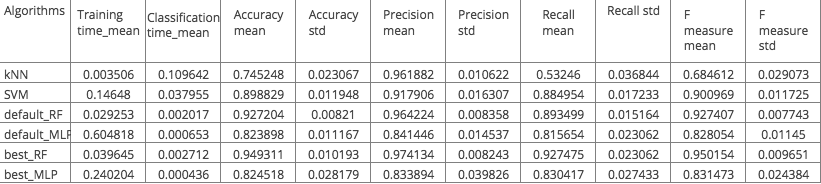

The above table shows the results of the average and standard deviation of classification performance on the test set regarding: accuracy, precision, recall, and F- Measure and the mean training time and mean classification time of all the methods.

### Why repeating classification 20 times

Repeating 20 times helps us to verify the model objectively. For example, the model might fit perfectly to one of the specifc training sets and test sets and get a perfect result but not as similarly apply to other training set and test.In this case, we give the split function a random value to a random state to generate the training set and test set. In addition, we want to calculate the mean and standard deivation for the accuracy, recall, precision and f-measure value. 20 times helps us reduce the system error.

## Q4

Firstly, kNN algorithm, the training time is the smallest, but the classification time is the largest, the overall accuracy score is the lowest as well, although it has higher precision score. Due to the low value of recall and F-measure, it is inappropriate to use kNN on this kind of data. Compared to kNN, SVM has longer training time but less classification time, the accuracy score is significantly higher, coming to nearly 90%. In terms of random forest classfier, it has the best performance comprehensively. Under the default setting, the overall accuracy is more than 92%, after parameters optimizing, it came to nearly 95%, with little increase in the training time. When it comes to MLP classifier, it took the longest time to train the model because of large amount of parameters, however, the performance is not that good, accuracy scores remain at the level of 82%, which is worse than SVM and random forest classfier. With the analysis done here, we may firstly consider implementing random forest when dealing with this kind of dataset, and SVM is not a bad choice as well, but we may need to conduct feature selection and feature extraction before training the model since it will take longer time when using SVM classifier.

## Q5

### If you had to remove 1 features from the dataset, which feature would you select to remove from the dataset and why?

We can select the feature based on feature selection method. First, tree-based estimators can be used to compute feature importances. So we can select a feature with lowest importance and remove from the dataset. The code below shows how to remove the lowest important feature. We run the model 200 times to make sure to remove the lowest importance feature. The below code will show the proccess:

In [207]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()

res = dict()
for i in range(200):
    model.fit(X, y)
    l = model.feature_importances_
    for j in range(len(l)):
        if j in res.keys():
            res[j] += l[j]
        else:
            res[j] = l[j]
i_fea = sorted(res.items(), key=lambda res: res[1])[0][0]
print("The feature we want to remove is feature", i_fea)

The feature we want to remove is feature 5


### What would have happened if you did classification on two dimensions only?

If the two dimensions are the most important two features and account for significant discriminating abilities, the classification result may not be bad. However, if they are not, most likely, the classification will output as underfitting, due to the lack of features information and discriminating abilities.

# Reference

https://www.datasciencecentral.com/profiles/blogs/introduction-to-classification-regression-trees-cart

http://scikit-learn.org/stable/modules/ensemble.html